In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets  
from sklearn.ensemble import RandomForestClassifier
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn import metrics  
from sklearn.tree import plot_tree
from sklearn import tree

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Creating path
path = r'C:\Users\nickr\OneDrive\Documents\Nick Bootcamp\Machine Learning\Data Sets'

In [5]:
pleasant = pd.read_csv(os.path.join(path, 'Weather_Prediction_Pleasant_Weather.csv'))

In [7]:
unscaled = pd.read_csv(os.path.join(path, 'weather_data.csv'))

In [9]:
unscaled.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_wind_speed,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_snow_depth,BASEL_sunshine,...,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_snow_depth,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
0,19600101,1,7,2.1,0.85,1.018,0.32,0.09,0,0.7,...,5,0.88,1.0003,0.45,0.34,0,4.7,8.5,6.0,10.9
1,19600102,1,6,2.1,0.84,1.018,0.36,1.05,0,1.1,...,7,0.91,1.0007,0.25,0.84,0,0.7,8.9,5.6,12.1
2,19600103,1,8,2.1,0.90,1.018,0.18,0.30,0,0.0,...,7,0.91,1.0096,0.17,0.08,0,0.1,10.5,8.1,12.9
3,19600104,1,3,2.1,0.92,1.018,0.58,0.00,0,4.1,...,7,0.86,1.0184,0.13,0.98,0,0.0,7.4,7.3,10.6
4,19600105,1,6,2.1,0.95,1.018,0.65,0.14,0,5.4,...,3,0.80,1.0328,0.46,0.00,0,5.7,5.7,3.0,8.4


In [11]:
# Removing columns related to Tours, Gdansk and Rome from the unscaled dataset

unscaled = unscaled.drop(['GDANSK_cloud_cover', 'GDANSK_humidity', 'GDANSK_precipitation', 'GDANSK_snow_depth', 'GDANSK_temp_mean', 'GDANSK_temp_min', 'GDANSK_temp_max',
                        'ROMA_cloud_cover', 'ROMA_wind_speed', 'ROMA_humidity', 'ROMA_pressure', 'ROMA_sunshine', 'ROMA_temp_mean',
                        'TOURS_wind_speed', 'TOURS_humidity', 'TOURS_pressure', 'TOURS_global_radiation', 'TOURS_precipitation', 'TOURS_temp_mean', 'TOURS_temp_min', 'TOURS_temp_max'], axis=1)

In [13]:
# Cleaning data for remaining weather stations to ensure shape can fit into prediction model

# Extract the different observation types

observation_types = ['cloud_cover', 'wind_speed', 'humidity', 'pressure',
                     'global_radiation', 'precipitation', 'snow_depth', 
                     'sunshine', 'temp_mean', 'temp_min', 'temp_max']

In [15]:
# Create a dictionary to store the count of stations for each observation type
station_counts = {}

for obs in observation_types:
    # Select columns related to the current observation type
    columns = [col for col in unscaled.columns if col.endswith(obs)]
    
    # Count the number of stations (i.e., the number of columns) for the current observation type
    station_counts[obs] = len(columns)

# Print the count of stations for each observation type
print("Number of stations covered by each observation type:")
for obs, count in station_counts.items():
    print(f"{obs}: {count} stations")

Number of stations covered by each observation type:
cloud_cover: 14 stations
wind_speed: 9 stations
humidity: 14 stations
pressure: 14 stations
global_radiation: 15 stations
precipitation: 15 stations
snow_depth: 6 stations
sunshine: 15 stations
temp_mean: 15 stations
temp_min: 15 stations
temp_max: 15 stations


In [17]:
# Columns Wind Speed and Snow Depth missing multiple entries which will affect model shape

# Dropping columns that end with wind_speed and snow_depth from the dataset

columns_to_drop = unscaled.filter(regex='(_wind_speed|_snow_depth)$').columns
columns_to_drop

Index(['BASEL_wind_speed', 'BASEL_snow_depth', 'DEBILT_wind_speed',
       'DUSSELDORF_wind_speed', 'DUSSELDORF_snow_depth', 'HEATHROW_snow_depth',
       'KASSEL_wind_speed', 'LJUBLJANA_wind_speed', 'MAASTRICHT_wind_speed',
       'MADRID_wind_speed', 'MUNCHENB_snow_depth', 'OSLO_wind_speed',
       'OSLO_snow_depth', 'SONNBLICK_wind_speed', 'VALENTIA_snow_depth'],
      dtype='object')

In [21]:
unscaled = unscaled.drop(columns=columns_to_drop)

KeyError: "['BASEL_wind_speed', 'BASEL_snow_depth', 'DEBILT_wind_speed', 'DUSSELDORF_wind_speed', 'DUSSELDORF_snow_depth', 'HEATHROW_snow_depth', 'KASSEL_wind_speed', 'LJUBLJANA_wind_speed', 'MAASTRICHT_wind_speed', 'MADRID_wind_speed', 'MUNCHENB_snow_depth', 'OSLO_wind_speed', 'OSLO_snow_depth', 'SONNBLICK_wind_speed', 'VALENTIA_snow_depth'] not found in axis"

In [23]:
unscaled.shape

(22950, 134)

In [25]:
# Columns cloud cover, humidity, and pressure are missing a single entry (14 stations instead of 15)

# Creating list of all unique station names in the dataset

all_stations = set([col.split('_')[0] for col in unscaled.columns if '_' in col])
all_stations

{'BASEL',
 'BELGRADE',
 'BUDAPEST',
 'DEBILT',
 'DUSSELDORF',
 'HEATHROW',
 'KASSEL',
 'LJUBLJANA',
 'MAASTRICHT',
 'MADRID',
 'MUNCHENB',
 'OSLO',
 'SONNBLICK',
 'STOCKHOLM',
 'VALENTIA'}

In [27]:
observation_types = ['cloud_cover', 'humidity', 'pressure']

missing_stations_by_observation = {}

for obs in observation_types:
    # Select columns related to the current observation type
    columns = [col for col in unscaled.columns if col.endswith(obs)]
    
    # Extract station names by removing the observation type from the column names
    station_names = set([col.replace(f'_{obs}', '') for col in columns])
    
    # Identify stations that are in all_stations but missing from the current observation type
    missing_stations = all_stations - station_names
    
    # Store the missing station names in the dictionary
    missing_stations_by_observation[obs] = missing_stations

# Print the missing station names for each observation type
for obs, missing_stations in missing_stations_by_observation.items():
    print(f"\nStations missing from {obs}:")
    if missing_stations:
        for station in missing_stations:
            print(station)
    else:
        print("None")


Stations missing from cloud_cover:
KASSEL

Stations missing from humidity:
STOCKHOLM

Stations missing from pressure:
MUNCHENB


In [29]:
# Get the position of HEATHROW_temp_max to see where we need to position the new KASSEL_cloud_cover  (+1 next to it)

unscaled.columns.get_loc('HEATHROW_temp_max')

55

In [31]:
unscaled.columns.get_loc('STOCKHOLM_cloud_cover') # +2

117

In [33]:
unscaled.columns.get_loc('MUNCHENB_humidity') # +2

92

In [35]:
# Insert new columns into "unscaled" at specific positions.
# The data for these new columns is copied from other existing columns:
# Kassel_cloud_cover with Dusseldorf_cloud_cover
# Stockholm_humidity with Oslo_humidity
# Munchenb_pressure with Basel_pressure

unscaled.insert(56,'KASSEL_cloud_cover', unscaled['DUSSELDORF_cloud_cover'])
unscaled.insert(119, 'STOCKHOLM_humidity', unscaled['OSLO_humidity'])
unscaled.insert(94,'MUNCHENB_pressure',unscaled['BASEL_pressure'])

In [37]:
unscaled.columns.tolist()

['DATE',
 'MONTH',
 'BASEL_cloud_cover',
 'BASEL_humidity',
 'BASEL_pressure',
 'BASEL_global_radiation',
 'BASEL_precipitation',
 'BASEL_sunshine',
 'BASEL_temp_mean',
 'BASEL_temp_min',
 'BASEL_temp_max',
 'BELGRADE_cloud_cover',
 'BELGRADE_humidity',
 'BELGRADE_pressure',
 'BELGRADE_global_radiation',
 'BELGRADE_precipitation',
 'BELGRADE_sunshine',
 'BELGRADE_temp_mean',
 'BELGRADE_temp_min',
 'BELGRADE_temp_max',
 'BUDAPEST_cloud_cover',
 'BUDAPEST_humidity',
 'BUDAPEST_pressure',
 'BUDAPEST_global_radiation',
 'BUDAPEST_precipitation',
 'BUDAPEST_sunshine',
 'BUDAPEST_temp_mean',
 'BUDAPEST_temp_min',
 'BUDAPEST_temp_max',
 'DEBILT_cloud_cover',
 'DEBILT_humidity',
 'DEBILT_pressure',
 'DEBILT_global_radiation',
 'DEBILT_precipitation',
 'DEBILT_sunshine',
 'DEBILT_temp_mean',
 'DEBILT_temp_min',
 'DEBILT_temp_max',
 'DUSSELDORF_cloud_cover',
 'DUSSELDORF_humidity',
 'DUSSELDORF_pressure',
 'DUSSELDORF_global_radiation',
 'DUSSELDORF_precipitation',
 'DUSSELDORF_sunshine',
 'DUSS

In [113]:
# Exporting cleaned unscaled dataset

unscaled.to_csv(os.path.join(path, 'unscaled_cleaned_weather_dated.csv'), index=False)

In [39]:
# Drop unnecessary columns

unscaled.drop(['MONTH'], axis=1, inplace=True)

In [41]:
unscaled.shape

(22950, 136)

In [47]:
X = unscaled

In [49]:
# Reducing dataset to 2000's

dfdecade = X[(X['DATE'].astype(str).str[:4] >= '2000') & (X['DATE'].astype(str).str[:4] <= '2009')]
dfdecade

,DATE,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,...,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
14610,20000101,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,3.9,...,0.7,6,0.89,1.0235,0.22,0.10,0.7,6.6,2.1,11.0
14611,20000102,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,4.8,...,2.0,8,0.92,1.0177,0.13,0.42,0.0,9.6,7.3,10.6
14612,20000103,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,4.8,...,2.8,4,0.79,1.0154,0.22,1.05,1.2,8.6,7.3,9.9
14613,20000104,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,7.5,...,4.6,6,0.76,1.0099,0.36,0.34,3.5,8.1,5.0,7.7
14614,20000105,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,8.6,...,2.9,7,0.81,0.9957,0.12,0.33,0.0,7.7,4.0,11.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18258,20091227,7,0.80,1.0118,0.37,0.18,2.3,1.0,-3.9,5.5,...,-2.7,4,0.72,1.0039,0.37,0.01,4.7,7.2,5.8,8.5
18259,20091228,7,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,4.8,...,2.4,8,0.70,0.9975,0.22,1.25,0.0,4.8,1.4,8.3
18260,20091229,7,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,10.0,...,0.8,8,0.88,0.9866,0.12,2.84,0.0,3.4,2.6,4.2
18261,20091230,8,0.92,0.9979,0.18,1.54,0.0,8.5,7.5,11.5,...,-7.4,8,0.87,0.9862,0.12,1.46,0.0,3.1,2.1,4.2


In [51]:
# Reducing pleasant dataset to 2000's

pleasant_decade = pleasant[(pleasant['DATE'].astype(str).str[:4] >= '2000') & (pleasant['DATE'].astype(str).str[:4] <= '2009')]
pleasant_decade

,DATE,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
14610,20000101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14611,20000102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14612,20000103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14613,20000104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14614,20000105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18258,20091227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18259,20091228,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18260,20091229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18261,20091230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
# Extract stations list

stations = [col.split('_')[0] for col in dfdecade.columns if '_' in col]

In [55]:
# Create a set of unique station names

unique_stations = set(stations)
unique_stations

{'BASEL',
 'BELGRADE',
 'BUDAPEST',
 'DEBILT',
 'DUSSELDORF',
 'HEATHROW',
 'KASSEL',
 'LJUBLJANA',
 'MAASTRICHT',
 'MADRID',
 'MUNCHENB',
 'OSLO',
 'SONNBLICK',
 'STOCKHOLM',
 'VALENTIA'}

In [57]:
# Create a dictionary to store the frequency of entries for each station
station_frequencies = {}

for station in unique_stations:
    # Select columns that belong to the current station
    station_columns = [col for col in  dfdecade.columns if col.startswith(station)]
    
    # Count non-missing entries across all columns for the station
    station_frequencies[station] =  dfdecade[station_columns].notna().sum().sum()

# Print the frequency of entries for each station
print("Frequency of entries for each weather station:")
for station, freq in station_frequencies.items():
    print(f"{station}: {freq} entries")

Frequency of entries for each weather station:
BELGRADE: 32877 entries
HEATHROW: 32877 entries
LJUBLJANA: 32877 entries
VALENTIA: 32877 entries
OSLO: 32877 entries
DUSSELDORF: 32877 entries
BUDAPEST: 32877 entries
DEBILT: 32877 entries
MADRID: 32877 entries
STOCKHOLM: 32877 entries
MAASTRICHT: 32877 entries
KASSEL: 32877 entries
MUNCHENB: 32877 entries
BASEL: 32877 entries
SONNBLICK: 32877 entries


In [59]:
# Dropping Date column

dfdecade.drop(['DATE'], axis=1, inplace=True)

In [61]:
dfdecade.shape

(3653, 135)

In [67]:
pleasant.head()

,DATE,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,19600101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,19600102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,19600103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,19600104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,19600105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
pleasant_decade.drop(columns = 'DATE', inplace = True)

In [73]:
pleasant_decade.shape

(3653, 15)

In [75]:
X = dfdecade

In [77]:
X.head()

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,BELGRADE_humidity,BELGRADE_pressure,BELGRADE_global_radiation,BELGRADE_precipitation,BELGRADE_sunshine,BELGRADE_temp_mean,BELGRADE_temp_min,BELGRADE_temp_max,BUDAPEST_cloud_cover,BUDAPEST_humidity,BUDAPEST_pressure,BUDAPEST_global_radiation,BUDAPEST_precipitation,BUDAPEST_sunshine,BUDAPEST_temp_mean,BUDAPEST_temp_min,BUDAPEST_temp_max,DEBILT_cloud_cover,DEBILT_humidity,DEBILT_pressure,DEBILT_global_radiation,DEBILT_precipitation,DEBILT_sunshine,DEBILT_temp_mean,DEBILT_temp_min,DEBILT_temp_max,DUSSELDORF_cloud_cover,DUSSELDORF_humidity,DUSSELDORF_pressure,DUSSELDORF_global_radiation,DUSSELDORF_precipitation,DUSSELDORF_sunshine,DUSSELDORF_temp_mean,DUSSELDORF_temp_min,DUSSELDORF_temp_max,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,KASSEL_cloud_cover,KASSEL_humidity,KASSEL_pressure,KASSEL_global_radiation,KASSEL_precipitation,KASSEL_sunshine,KASSEL_temp_mean,KASSEL_temp_min,KASSEL_temp_max,LJUBLJANA_cloud_cover,LJUBLJANA_humidity,LJUBLJANA_pressure,LJUBLJANA_global_radiation,LJUBLJANA_precipitation,LJUBLJANA_sunshine,LJUBLJANA_temp_mean,LJUBLJANA_temp_min,LJUBLJANA_temp_max,MAASTRICHT_cloud_cover,MAASTRICHT_humidity,MAASTRICHT_pressure,MAASTRICHT_global_radiation,MAASTRICHT_precipitation,MAASTRICHT_sunshine,MAASTRICHT_temp_mean,MAASTRICHT_temp_min,MAASTRICHT_temp_max,MADRID_cloud_cover,MADRID_humidity,MADRID_pressure,MADRID_global_radiation,MADRID_precipitation,MADRID_sunshine,MADRID_temp_mean,MADRID_temp_min,MADRID_temp_max,MUNCHENB_cloud_cover,MUNCHENB_humidity,MUNCHENB_pressure,MUNCHENB_global_radiation,MUNCHENB_precipitation,MUNCHENB_sunshine,MUNCHENB_temp_mean,MUNCHENB_temp_min,MUNCHENB_temp_max,OSLO_cloud_cover,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_sunshine,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max,SONNBLICK_cloud_cover,SONNBLICK_humidity,SONNBLICK_pressure,SONNBLICK_global_radiation,SONNBLICK_precipitation,SONNBLICK_sunshine,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,STOCKHOLM_cloud_cover,STOCKHOLM_humidity,STOCKHOLM_pressure,STOCKHOLM_global_radiation,STOCKHOLM_precipitation,STOCKHOLM_sunshine,STOCKHOLM_temp_mean,STOCKHOLM_temp_min,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
14610,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,3.9,7,0.88,1.0275,0.24,0.0,0.0,-2.5,-3.2,-0.4,3,0.92,1.0268,0.52,0.0,3.7,-4.9,-8.4,-0.7,7,0.97,1.0240,0.14,0.10,0.0,6.1,3.5,8.1,8,0.92,1.0240,0.12,0.22,0.0,4.2,2.5,6.9,7,0.94,1.0245,0.18,0.00,0.4,7.0,4.9,10.8,8,0.93,1.0237,0.12,0.13,0.0,3.5,1.5,5.0,6,0.83,1.0294,0.57,0.0,5.2,-4.8,-9.1,-1.3,8,0.98,1.0251,0.12,0.17,0.0,5.6,4.1,6.9,1,0.80,1.0282,1.02,0.0,8.4,5.4,0.3,10.4,8,0.91,1.0286,0.20,0.20,0.0,1.7,-0.5,2.6,7,0.94,1.0130,-0.03,0.60,0.0,-5.0,-8.6,-3.2,7,0.89,1.0420,0.82,1.34,0.0,-15.2,-17.0,-13.4,8,0.94,1.0163,0.05,0.17,0.0,-2.3,-9.3,0.7,6,0.89,1.0235,0.22,0.10,0.7,6.6,2.1,11.0
14611,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,4.8,8,0.85,1.0303,0.25,0.0,0.0,-1.2,-2.6,-0.3,8,0.94,1.0297,0.14,0.0,0.4,-3.6,-5.0,-1.9,8,0.97,1.0267,0.08,0.00,0.0,7.3,5.4,8.7,6,0.87,1.0283,0.19,0.00,0.7,6.5,2.7,7.9,7,0.89,1.0253,0.20,0.02,0.7,7.9,5.0,11.5,6,0.92,1.0290,0.33,0.00,2.9,2.3,0.3,4.7,6,0.76,1.0310,0.59,0.0,5.0,-0.9,-4.9,2.0,7,0.95,1.0286,0.14,0.00,0.0,6.2,4.2,7.5,0,0.78,1.0279,1.03,0.0,8.5,5.0,0.3,9.6,6,0.90,1.0318,0.66,0.00,6.1,1.9,-0.2,5.8,6,0.94,1.0076,-0.03,0.00,1.6,-0.8,-6.7,2.4,5,0.86,1.0467,0.60,0.39,2.8,-13.7,-15.0,-12.3,8,0.94,1.0108,0.05,0.20,0.0,1.3,0.5,2.0,8,0.92,1.0177,0.13,0.42,0.0,9.6,7.3,10.6
14612,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,4.8,5,0.84,1.0310,0.50,0.0,1.4,-1.0,-3.4,1.4,6,0.95,1.0295,0.19,0.0,0.0,-0.8,

In [79]:
X.shape

(3653, 135)

In [81]:
y = pleasant_decade

In [83]:
# Turn X and y from a df to arrays

X = np.array(X)
y = np.array(y)

In [85]:
# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [87]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2739, 135) (2739, 15)
(914, 135) (914, 15)


In [89]:
# Creating a Random Forest Model
# Create a RF classifier
clf = RandomForestClassifier(n_estimators = 100)#, max_depth=5)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)

RandomForestClassifier()

In [91]:
# Perform predictions on the test dataset
y_pred = clf.predict(X_test)
  
# Use metrics module for accuracy calculation
print("Model Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Model Accuracy:  0.5853391684901532


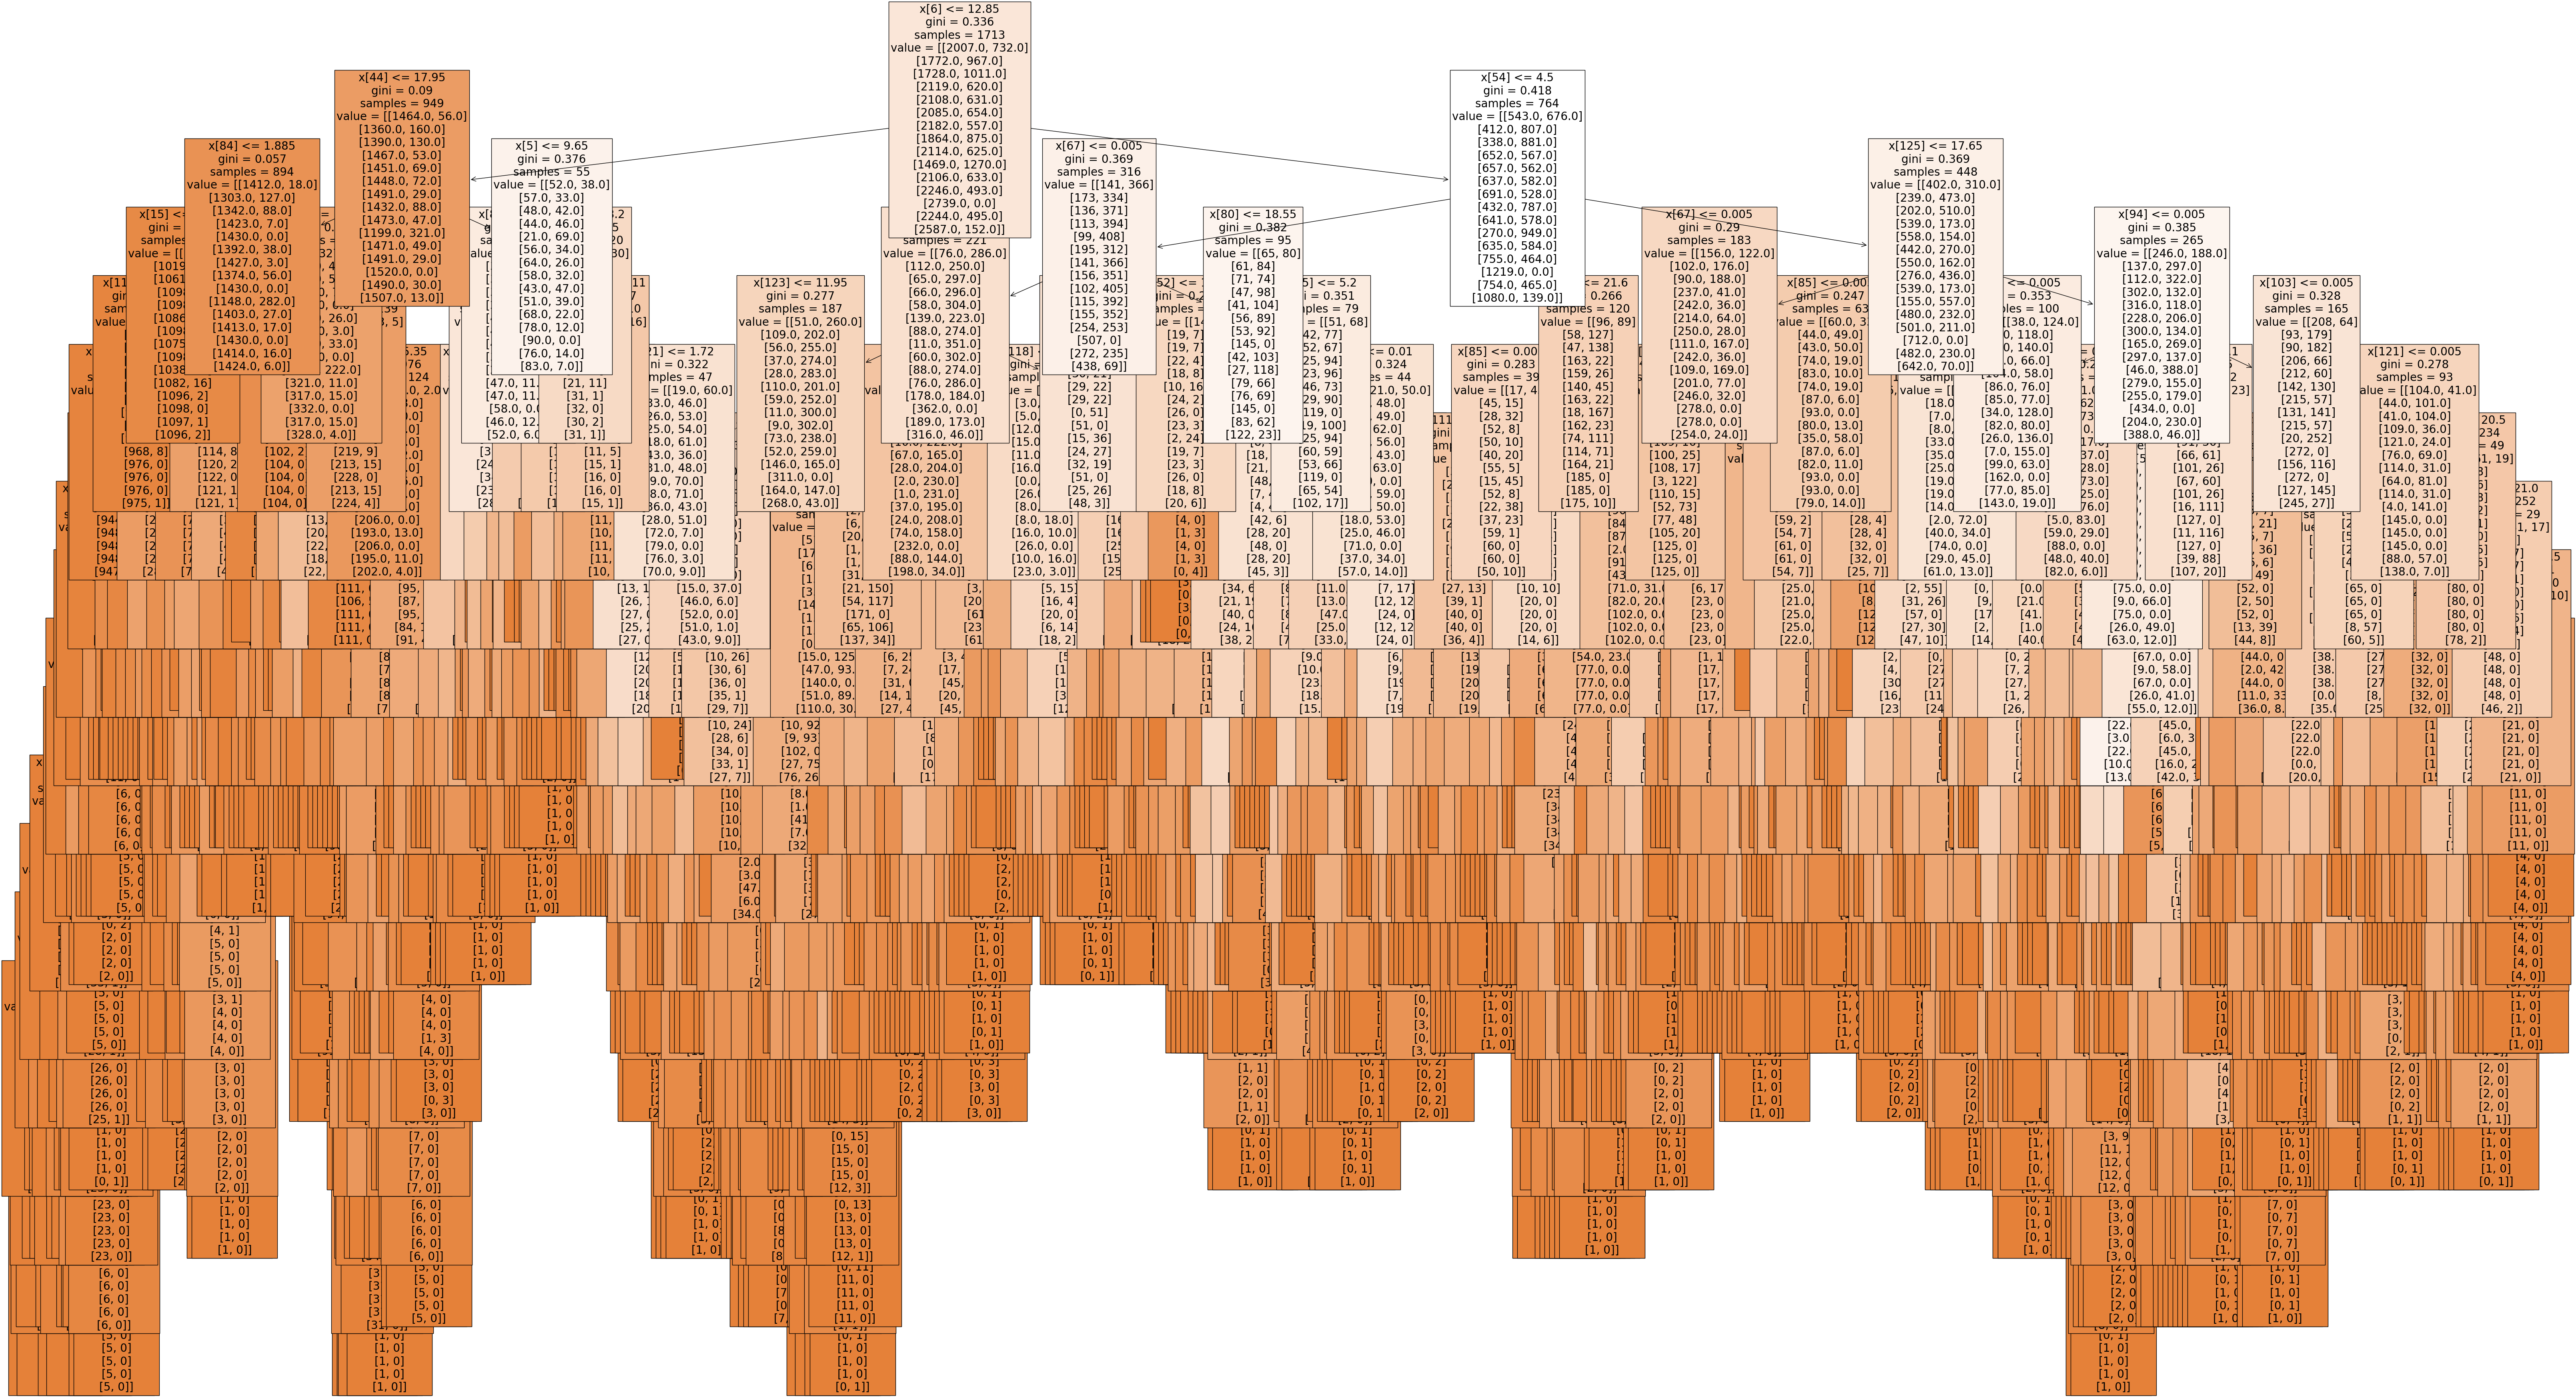

In [93]:
# Class-names = {0:'Unpleasant Weather', 1:'Pleasant Weather'}

fig = plt.figure(figsize=(80,40))
plot_tree(clf.estimators_[15], fontsize = 20, filled=True);

In [95]:
fig.savefig(os.path.join(path, 'Visualizations', 'random_forest_2000s.png'),bbox_inches='tight')

In [97]:
# Discovering Feature Importances
# Retrieve feature importances from the trained model

newarray = clf.feature_importances_
print(clf.feature_importances_.shape)
newarray

(135,)


array([0.0022078 , 0.00305746, 0.00297703, 0.00447354, 0.0156326 ,
       0.00649025, 0.01306371, 0.00302262, 0.02631482, 0.00383682,
       0.0037152 , 0.00346016, 0.00429765, 0.01523288, 0.00439593,
       0.00951079, 0.00522506, 0.00855681, 0.00261801, 0.0037996 ,
       0.00287441, 0.00421017, 0.01101196, 0.00423284, 0.00892936,
       0.0051281 , 0.01472912, 0.0040423 , 0.00302107, 0.00463692,
       0.00464447, 0.01358327, 0.00554519, 0.01025499, 0.0026216 ,
       0.03251867, 0.00725282, 0.00256086, 0.00388495, 0.00483514,
       0.01891143, 0.00556518, 0.0200906 , 0.00270629, 0.04772155,
       0.00204923, 0.00356295, 0.00365393, 0.00533632, 0.00969097,
       0.00362947, 0.00506765, 0.00299887, 0.0137152 , 0.00486753,
       0.00266821, 0.00408588, 0.00271774, 0.01394738, 0.00354473,
       0.02193069, 0.00279638, 0.02462087, 0.00353155, 0.0039555 ,
       0.00273251, 0.00451188, 0.01543353, 0.00464574, 0.00974015,
       0.00262685, 0.01274587, 0.00374454, 0.00286922, 0.00358

In [99]:
# Reshape newarray

newarray = newarray.reshape(-1,15,9)
print(newarray.shape)
newarray

(1, 15, 9)


array([[[0.0022078 , 0.00305746, 0.00297703, 0.00447354, 0.0156326 ,
         0.00649025, 0.01306371, 0.00302262, 0.02631482],
        [0.00383682, 0.0037152 , 0.00346016, 0.00429765, 0.01523288,
         0.00439593, 0.00951079, 0.00522506, 0.00855681],
        [0.00261801, 0.0037996 , 0.00287441, 0.00421017, 0.01101196,
         0.00423284, 0.00892936, 0.0051281 , 0.01472912],
        [0.0040423 , 0.00302107, 0.00463692, 0.00464447, 0.01358327,
         0.00554519, 0.01025499, 0.0026216 , 0.03251867],
        [0.00725282, 0.00256086, 0.00388495, 0.00483514, 0.01891143,
         0.00556518, 0.0200906 , 0.00270629, 0.04772155],
        [0.00204923, 0.00356295, 0.00365393, 0.00533632, 0.00969097,
         0.00362947, 0.00506765, 0.00299887, 0.0137152 ],
        [0.00486753, 0.00266821, 0.00408588, 0.00271774, 0.01394738,
         0.00354473, 0.02193069, 0.00279638, 0.02462087],
        [0.00353155, 0.0039555 , 0.00273251, 0.00451188, 0.01543353,
         0.00464574, 0.00974015, 0.0026268

In [101]:
# Collapse this shape into one observation for each weather station

sumarray = np.sum(newarray[0], axis=1)
sumarray

array([0.07723983, 0.0582313 , 0.05753358, 0.08086847, 0.11352881,
       0.0497046 , 0.08117941, 0.05992359, 0.09748759, 0.06118343,
       0.10095151, 0.05352507, 0.02841668, 0.05358655, 0.02663958])

In [103]:
# Convert the set of unique stations to a list

unique_stations_list = list(unique_stations)

In [105]:
important = pd.Series(sumarray, index = unique_stations_list)
important = important.sort_values(ascending = False)
important

OSLO          0.113529
MAASTRICHT    0.100952
MADRID        0.097488
BUDAPEST      0.081179
VALENTIA      0.080868
BELGRADE      0.077240
STOCKHOLM     0.061183
DEBILT        0.059924
HEATHROW      0.058231
LJUBLJANA     0.057534
BASEL         0.053587
KASSEL        0.053525
DUSSELDORF    0.049705
MUNCHENB      0.028417
SONNBLICK     0.026640
dtype: float64

In [107]:
# Create a df to associate weather stations with their importances

df_importance = pd.DataFrame({
    'Weather Station': unique_stations_list,
    'Importance': sumarray
})

df_importance = df_importance.sort_values(by='Importance', ascending = False)

['BELGRADE', 'HEATHROW', 'LJUBLJANA', 'VALENTIA', 'OSLO', 'DUSSELDORF', 'BUDAPEST', 'DEBILT', 'MADRID', 'STOCKHOLM', 'MAASTRICHT', 'KASSEL', 'MUNCHENB', 'BASEL', 'SONNBLICK']


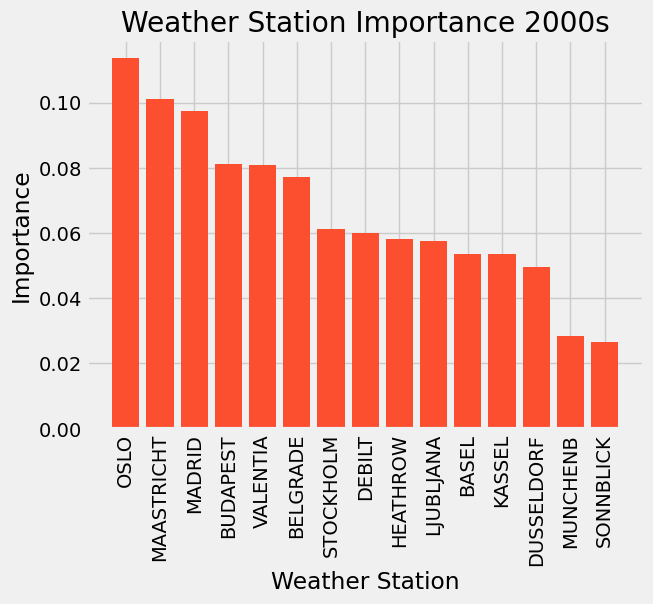

In [111]:
# Plot the results

%matplotlib inline

plt.style.use('fivethirtyeight')
print(unique_stations_list)

plt.bar(df_importance['Weather Station'], df_importance['Importance'], orientation = 'vertical')
plt.xticks(rotation='vertical')
plt.xlabel('Weather Station')
plt.ylabel('Importance')
plt.title('Weather Station Importance 2000s')

plt.savefig(os.path.join(path, 'Visualizations', '2000s_feauture_importances.png'), bbox_inches='tight')

plt.show()